In [2]:
import os

imdb_dir = 'C:\\Users\\karun\\Downloads\\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Cuts off reviews after 100 words
maxlen = 150
training_samples = 10000
validation_samples = 2000
test_samples = 4000

# Considers only the top 10,000 words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [4]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

"""
Splits the data into a training set and a
validation set, but first shuffles the data,
because you’re starting with data in which
samples are ordered (all negative first, then
all positive)
"""

indices = np.arange(data.shape[0])


Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [5]:
indices

array([    0,     1,     2, ..., 24997, 24998, 24999])

In [6]:
data

array([[   0,    0,    0, ...,   27,  107, 3348],
       [ 114,  750,  469, ...,    1, 4517, 5457],
       [   0,    0,    0, ..., 1906,   15,  620],
       ...,
       [  17,    6,    1, ..., 1110,  205, 9755],
       [  15,  150,   72, ..., 3713,   14,   70],
       [ 450,   36,  164, ...,   82,   93,   36]])

In [7]:
data.shape

(25000, 150)

In [8]:
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [9]:
indices

array([ 7643,  1102, 10009, ..., 16038, 11569, 24684])

In [10]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples: training_samples + validation_samples + test_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples + test_samples]

<b>PREPROCESSING THE EMBEDDINGS</b>

In [11]:
glove_dir = 'C:\\Users\\karun\\Downloads\\glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]         # in glove it is in format word followed by vector representation
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.3))
#model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2880064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,880,129
Trainable params: 5,880,129
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [15]:
from keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.95), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 9s 891us/step - loss: 0.7026 - acc: 0.6068 - val_loss: 0.5628 - val_acc: 0.7210
Epoch 2/10
10000/10000 [==============================] - 9s 870us/step - loss: 0.4706 - acc: 0.7824 - val_loss: 0.6007 - val_acc: 0.6840
Epoch 3/10
10000/10000 [==============================] - 9s 873us/step - loss: 0.3190 - acc: 0.8717 - val_loss: 0.5428 - val_acc: 0.7480
Epoch 4/10
10000/10000 [==============================] - 9s 893us/step - loss: 0.2122 - acc: 0.9176 - val_loss: 0.5827 - val_acc: 0.7410
Epoch 5/10
10000/10000 [==============================] - 10s 967us/step - loss: 0.1450 - acc: 0.9503 - val_loss: 0.6626 - val_acc: 0.7345
Epoch 6/10
10000/10000 [==============================] - 9s 921us/step - loss: 0.1003 - acc: 0.9664 - val_loss: 0.7205 - val_acc: 0.7405
Epoch 7/10
10000/10000 [===

In [30]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(embedding_dim))
model.add(Dense(1, activation='sigmoid'))


model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.9), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 96s 10ms/step - loss: 0.6542 - acc: 0.6423 - val_loss: 1.3273 - val_acc: 0.5820
Epoch 2/10
10000/10000 [==============================] - 98s 10ms/step - loss: 0.5940 - acc: 0.7003 - val_loss: 0.6178 - val_acc: 0.6580
Epoch 3/10
10000/10000 [==============================] - 99s 10ms/step - loss: 0.5007 - acc: 0.7586 - val_loss: 0.6402 - val_acc: 0.7065
Epoch 4/10
10000/10000 [==============================] - 98s 10ms/step - loss: 0.4425 - acc: 0.7993 - val_loss: 0.6149 - val_acc: 0.6730
Epoch 5/10
10000/10000 [==============================] - 99s 10ms/step - loss: 0.3964 - acc: 0.8257 - val_loss: 0.5172 - val_acc: 0.7710
Epoch 6/10
10000/10000 [==============================] - 99s 10ms/step - loss: 0.3547 - acc: 0.8465 - val_loss: 0.3599 - val_acc: 0.8460
Epoch 7/10
10000/10000 [==============================] - 104s 10ms/step - loss: 0.3226 - acc: 0.8627 - val_loss: 0.7456 - 

In [16]:
model.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.95), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 9s 915us/step - loss: 0.0106 - acc: 0.9983 - val_loss: 1.1696 - val_acc: 0.7400
Epoch 2/10
10000/10000 [==============================] - 9s 884us/step - loss: 0.0094 - acc: 0.9982 - val_loss: 1.1691 - val_acc: 0.7330
Epoch 3/10
10000/10000 [==============================] - 9s 902us/step - loss: 0.0078 - acc: 0.9985 - val_loss: 1.1969 - val_acc: 0.7360
Epoch 4/10
10000/10000 [==============================] - 9s 884us/step - loss: 0.0067 - acc: 0.9986 - val_loss: 1.2130 - val_acc: 0.7330
Epoch 5/10
10000/10000 [==============================] - 9s 885us/step - loss: 0.0063 - acc: 0.9987 - val_loss: 1.2269 - val_acc: 0.7315
Epoch 6/10
10000/10000 [==============================] - 9s 885us/step - loss: 0.0057 - acc: 0.9989 - val_loss: 1.2572 - val_acc: 0.7370
Epoch 7/10
10000/10000 [==============================] - 9s 893us/step - loss: 0.0048 - acc: 0.9991 - val_loss: 1.2747 - v

In [17]:
model.compile(optimizer=RMSprop(learning_rate=0.00001, rho=0.95), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 9s 903us/step - loss: 0.0031 - acc: 0.9991 - val_loss: 1.3431 - val_acc: 0.7360
Epoch 2/10
10000/10000 [==============================] - 9s 886us/step - loss: 0.0037 - acc: 0.9989 - val_loss: 1.3421 - val_acc: 0.7365
Epoch 3/10
10000/10000 [==============================] - 9s 887us/step - loss: 0.0031 - acc: 0.9994 - val_loss: 1.3435 - val_acc: 0.7370
Epoch 4/10
10000/10000 [==============================] - 9s 885us/step - loss: 0.0032 - acc: 0.9993 - val_loss: 1.3434 - val_acc: 0.7345
Epoch 5/10
10000/10000 [==============================] - 9s 891us/step - loss: 0.0032 - acc: 0.9993 - val_loss: 1.3480 - val_acc: 0.7360
Epoch 6/10
10000/10000 [==============================] - 9s 905us/step - loss: 0.0027 - acc: 0.9993 - val_loss: 1.3519 - val_acc: 0.7370
Epoch 7/10
10000/10000 [==============================] - 9s 890us/step - loss: 0.0031 - acc: 0.9994 - val_loss: 1.3527 - v

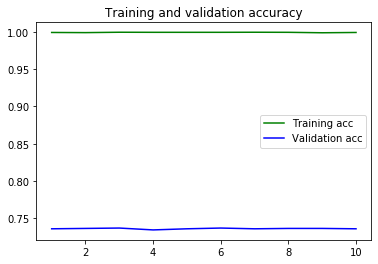

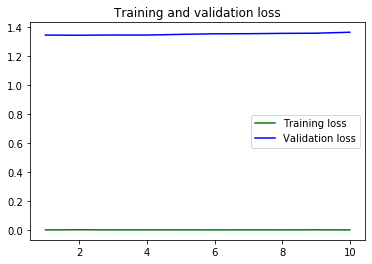

In [18]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
results = model.evaluate(x_test, y_test)
print(results)

4000/4000 [==============================] - 1s 150us/step
[1.3844786918163299, 0.7462499737739563]


<b> Training without PreTrained Embedding </b>

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 300)          3000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1440032   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,440,065
Trainable params: 4,440,065
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 15s 2ms/step - loss: 0.4810 - acc: 0.7485 - val_loss: 0.3375 - val_acc: 0.8565
Epoch 2/10
10000/10000 [==============================] 

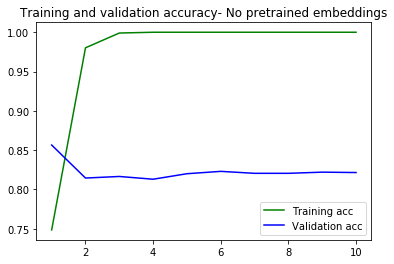

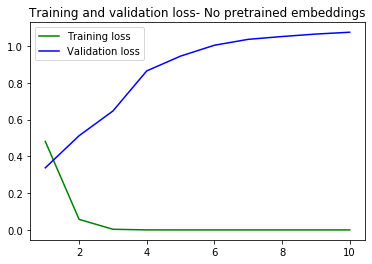

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy- No pretrained embeddings')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss- No pretrained embeddings')
plt.legend()
plt.show()

In [22]:
results = model.evaluate(x_test, y_test)
print(results)

4000/4000 [==============================] - 0s 98us/step
[1.1432013804912566, 0.8159999847412109]


In [25]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.9), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 8s 763us/step - loss: 0.5929 - acc: 0.6866 - val_loss: 0.4969 - val_acc: 0.7635
Epoch 2/10
10000/10000 [==============================] - 9s 867us/step - loss: 0.3663 - acc: 0.8558 - val_loss: 0.4105 - val_acc: 0.8420
Epoch 3/10
10000/10000 [==============================] - 9s 876us/step - loss: 0.2717 - acc: 0.8966 - val_loss: 0.3628 - val_acc: 0.8520
Epoch 4/10
10000/10000 [==============================] - 9s 887us/step - loss: 0.2083 - acc: 0.9242 - val_loss: 0.4258 - val_acc: 0.8100
Epoch 5/10
10000/10000 [==============================] - 9s 880us/step - loss: 0.1742 - acc: 0.9375 - val_loss: 0.3246 - val_acc: 0.8705
Epoch 6/10
10000/10000 [==============================] - 9s 877us/step - loss: 0.1390 - acc: 0.9519 - val_loss: 0.4184 - val_acc: 0.8555
Epoch 7/10
10000/10000 [==============================] - 9s 912us/step - loss: 0.1179 - acc: 0.9614 - val_loss: 0.3678 - v

In [27]:
model.compile(optimizer=RMSprop(learning_rate=0.0001, rho=0.80), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 8s 769us/step - loss: 0.0211 - acc: 0.9956 - val_loss: 0.5509 - val_acc: 0.8495
Epoch 2/10
10000/10000 [==============================] - 7s 727us/step - loss: 0.0204 - acc: 0.9961 - val_loss: 0.6027 - val_acc: 0.8465
Epoch 3/10
 9600/10000 [===========================>..] - ETA: 0s - loss: 0.0199 - acc: 0.9960

KeyboardInterrupt: 